In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_PATH = Path('../data/cleaned')

fact_events = DATA_PATH / 'fact_events_cleaned.parquet'
fact_products = DATA_PATH / 'fact_product_cleaned.parquet'

df_events = pd.read_parquet(fact_events)
df_products = pd.read_parquet(fact_products)

In [66]:
df_events.info()
sns.set_style('ticks')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251084 entries, 0 to 2251083
Data columns (total 17 columns):
 #   Column                Dtype              
---  ------                -----              
 0   user_id               object             
 1   event_name            category           
 2   transaction_id        object             
 3   event_date            datetime64[ns]     
 4   event_ts              datetime64[us, UTC]
 5   engagement_time_msec  Int64              
 6   session_id            Int64              
 7   device                category           
 8   country               category           
 9   region                object             
 10  city                  object             
 11  traffic_sname         object             
 12  traffic_smedium       object             
 13  traffic_source        object             
 14  marketing_channel     category           
 15  is_purchase           bool               
 16  is_engaged_event      boolean       

---
## 1️⃣Where do users drop off in the funnel?
---

In [155]:
funnel = [
    'view_item'    
    ,'add_to_cart'   
    ,'begin_checkout'   
    ,'add_shipping_info'   
    ,'add_payment_info'   
    ,'purchase'   
]

funnel_events = (
    df_events[df_events['event_name'].isin(funnel)]
    .groupby('event_name',observed=True)['user_id']
    .nunique()
    .reindex(funnel)
    .reset_index()
)  

funnel_events.columns = ['stage', 'user_count']


funnel_events['drop_off_pct'] = (
    1 - (funnel_events['user_count'] / funnel_events['user_count'].shift(1))
)
funnel_events

,stage,user_count,drop_off_pct
0,view_item,61252,NaN
1,add_to_cart,12545,0.795190
2,begin_checkout,9715,0.225588
3,add_shipping_info,9714,0.000103
4,add_payment_info,5751,0.407968
5,purchase,4419,0.231612


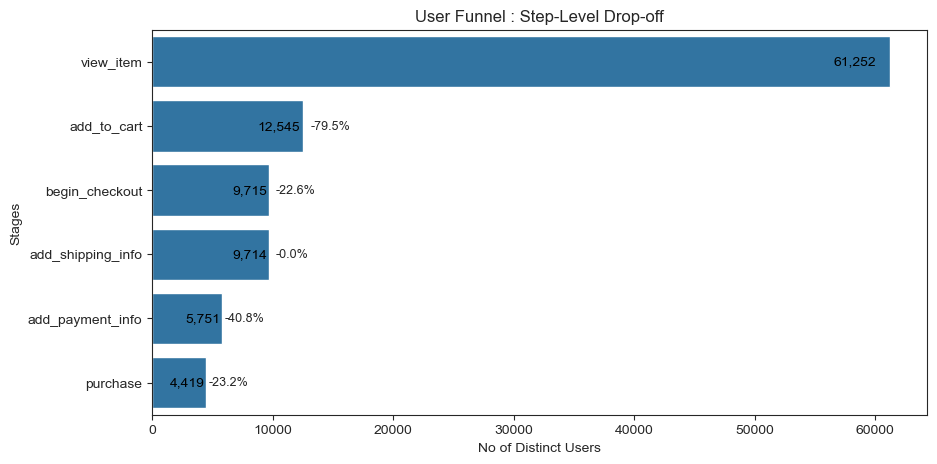

In [154]:
plt.figure(figsize = (10,5))
sns.barplot(
    data=funnel_events,
    y='stage',
    x='user_count',
)

for i, row in funnel_events.iterrows():
    plt.text(
        row['user_count'] * .98,
        i,
        f"{row['user_count']:,}",
        va = 'center',
        ha = 'right',
        color = 'black'
    )
for i, row in funnel_events.iterrows():
    if row['drop_off_pct'] > 0:
        plt.text(
            row['user_count'] * 1.05,
            i,
            f"-{row['drop_off_pct']:.1%}",
            va = 'center',
            fontsize = 9
        )
plt.title('User Funnel : Step-Level Drop-off')
plt.ylabel('Stages')
plt.xlabel('No of Distinct Users')
plt.show()

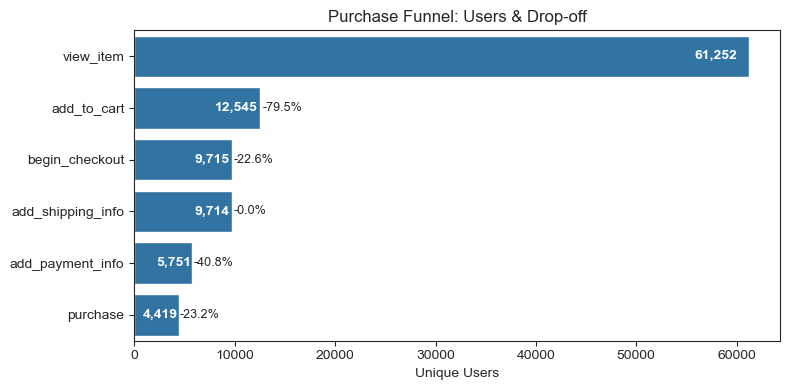

In [ ]:
plt.figure(figsize=(8, 4))

ax = sns.barplot(
    data=funnel_events,
    y='stage',
    x='user_count',
)


ax.set_title('Purchase Funnel: Users & Drop-off')
ax.set_xlabel('Unique Users')
ax.set_ylabel('')

# Annotate counts and drop-off %
for i, row in funnel_events.iterrows():
    ax.text(
        row['user_count'] * 0.98,
        i,
        f"{row['user_count']:,}",
        va='center',
        ha='right',
        color='white',
        fontsize=10,
        fontweight='bold'
    )

    if i > 0:
        ax.text(
            row['user_count'] * 1.02,
            i,
            f"-{row['drop_off_pct']:.1%}",
            va='center',
            fontsize=9,
            
        )

plt.tight_layout()
plt.show()
